In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data = pd.read_csv('Crime_Incidents_4271237485119492148.csv')
print(data.head())

C:\Users\gresn\AppData\Local\Temp\ipykernel_31132\353160197.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('Crime_Incidents_4271237485119492148.csv')


   OBJECTID       PrimaryKey     CaseNumber    District  \
0         1  201600000036001  2016-00000036  District 3   
1         2  201600000112001  2016-00000112  District O   
2         3  201600000128003  2016-00000128  District 5   
3         4  201600000265001  2016-00000265  District O   
4         5  201600000268003  2016-00000268  District 3   

                 UCRdesc  OffenseYear TimeGroup         ReportedDate  \
0                Weapons         2016     Older  1/1/2016 5:10:00 AM   
1                Assault         2016     Older  1/1/2016 5:51:00 AM   
2  Drug Abuse Violations         2016     Older  1/1/2016 5:58:00 AM   
3              Vandalism         2016     Older  1/1/2016 7:30:00 AM   
4                Weapons         2016     Older  1/1/2016 7:32:13 AM   

   OffenseMonth  OffenseDay  ...          CENSUS_TRACT CENSUS_TRACT_GEOID  \
0             1           1  ...     Census Tract 1122        39035112200   
1             1           1  ...     Census Tract 1238    

In [40]:
# just 2025 data
data25 = data[data['OffenseYear'] == 2025]

# inside CWRU coordinate box
min_lat = 41.498901
max_lat = 41.515741
min_lon = -81.615495
max_lon = -81.597317

filtered_df = data25[
    (data25['LAT'] >= min_lat) &
    (data25['LAT'] <= max_lat) &
    (data25['LON'] >= min_lon) &
    (data25['LON'] <= max_lon)
]

district3 = data25[data25['District'] == "District 3"]

# Outside CWRU but still in District 3
outside_cwru = district3[
    (district3['LAT'] < min_lat) |
    (district3['LAT'] > max_lat) |
    (district3['LON'] < min_lon) |
    (district3['LON'] > max_lon)
]

outside_offenses_per_month = (
    outside_cwru['OffenseMonth']
    .value_counts()
    .sort_index()
    .rename_axis('Month')
    .reset_index(name='OffenseCount')
)

cwru_offenses_per_month = (
    filtered_df['OffenseMonth']
    .value_counts()
    .sort_index()
    .rename_axis('Month')
    .reset_index(name='OffenseCount')
)

print(cwru_offenses_per_month)

    Month  OffenseCount
0       1            66
1       2            53
2       3            71
3       4            82
4       5            97
5       6            85
6       7            62
7       8            74
8       9            48
9      10            65
10     11             7


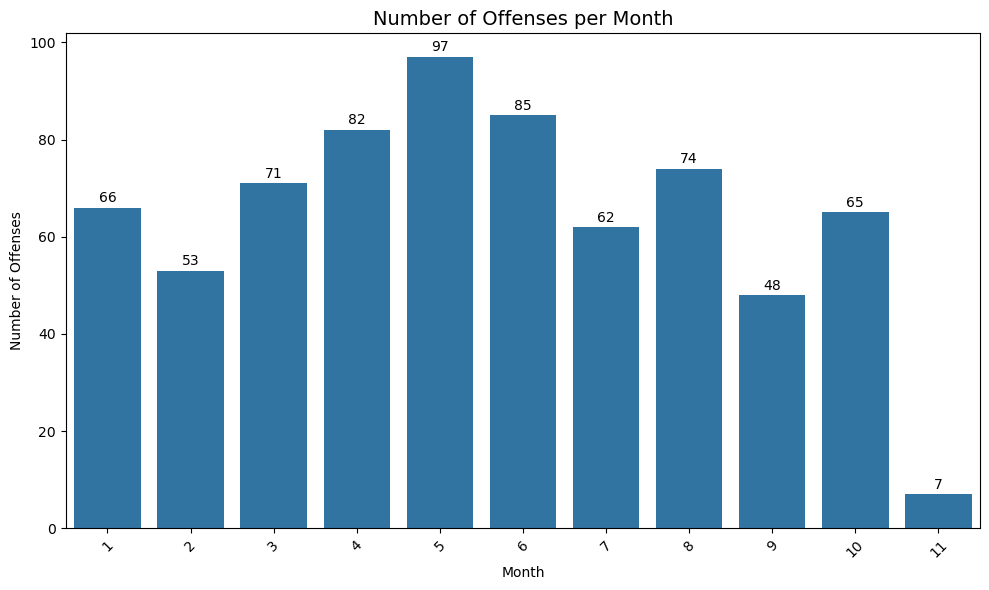

In [28]:
#Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=offenses_per_month,
    x='Month', y='OffenseCount',
)

#value labels above bars
for i, value in enumerate(offenses_per_month['OffenseCount']):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

plt.title('Number of Offenses per Month', fontsize=14)
plt.xlabel('Month')
plt.ylabel('Number of Offenses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

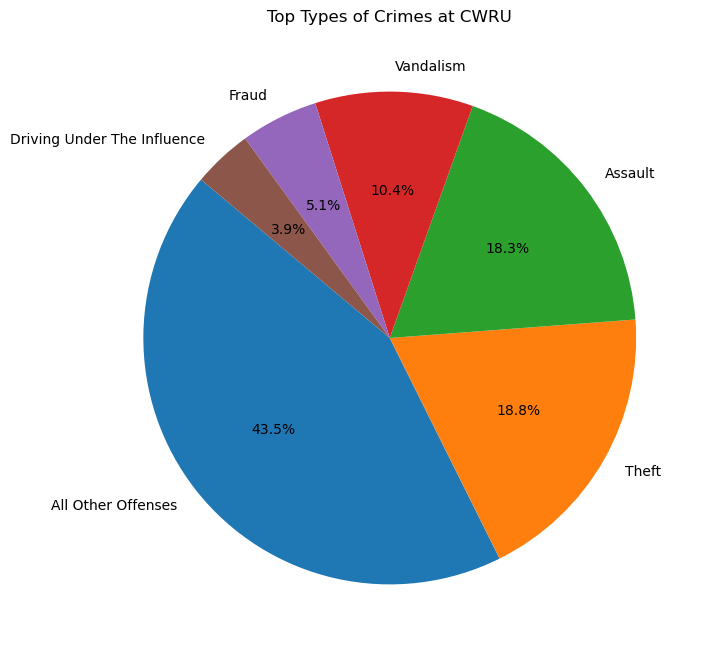

In [35]:
# Types of crimes at CWRU
top6 = filtered_df['UCRdesc'].value_counts().nlargest(6)

# Compute percentages
percentages = top6 / top6.sum() * 100

# Create pie chart
plt.figure(figsize=(8,8))
plt.pie(percentages, labels=top6.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Types of Crimes at CWRU')
plt.show()

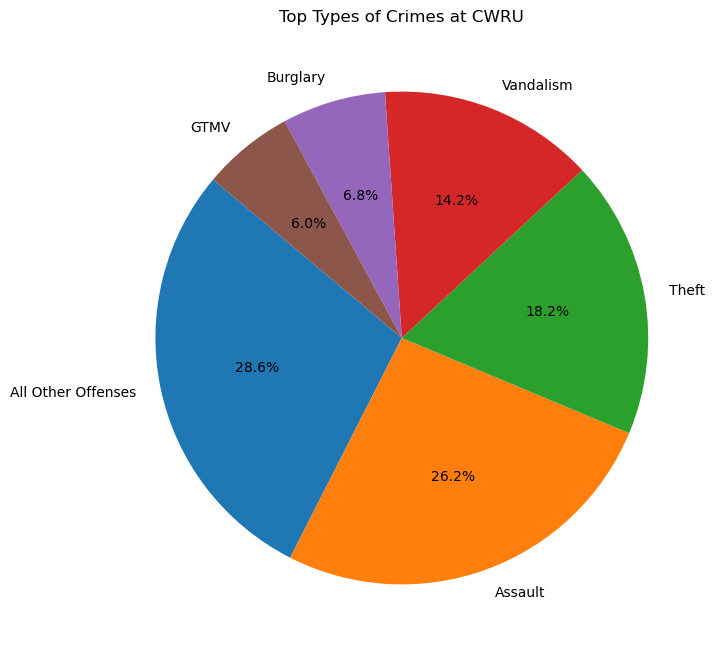

In [36]:
# Types of crimes in cle
top6 = data['UCRdesc'].value_counts().nlargest(6)

# Compute percentages
percentages = top6 / top6.sum() * 100

# Create pie chart
plt.figure(figsize=(8,8))
plt.pie(percentages, labels=top6.index, autopct='%1.1f%%', startangle=140)
plt.title('Top Types of Crimes at CWRU')
plt.show()

In [41]:
# ---- Combine results ----
comparison = cwru_offenses_per_month.merge(
    outside_offenses_per_month,
    on='Month',
    how='outer',
    suffixes=('_CWRU', '_District3Outside')
).fillna(0)

print(comparison)

    Month  OffenseCount_CWRU  OffenseCount_District3Outside
0       1                 66                           1084
1       2                 53                            978
2       3                 71                           1170
3       4                 82                           1253
4       5                 97                           1350
5       6                 85                           1319
6       7                 62                           1384
7       8                 74                           1258
8       9                 48                           1208
9      10                 65                           1168
10     11                  7                            286


In [51]:

import folium
import pandas as pd
import numpy as np

map_center = [41.506, -81.606]
cwru_box = [
    [min_lat, min_lon],
    [min_lat, max_lon],
    [max_lat, max_lon],
    [max_lat, min_lon],
    [min_lat, min_lon],
]


# Round coordinates slightly to cluster nearby points
district3['lat_rounded'] = district3['LAT'].round(3)
district3['lon_rounded'] = district3['LON'].round(3)

# Aggregate by approximate location
location_counts = (
    district3.groupby(['lat_rounded', 'lon_rounded'])
    .size()
    .reset_index(name='count')
)

# Create base map
m2 = folium.Map(location=map_center, zoom_start=13)

# Add proportional circle markers
for _, row in location_counts.iterrows():
    folium.CircleMarker(
        location=[row['lat_rounded'], row['lon_rounded']],
        radius=np.sqrt(row['count']) * 1.5,  # scale marker size
        color='crimson',
        fill=True,
        fill_opacity=0.5,
        popup=f"Offenses: {row['count']}"
    ).add_to(m2)

# Add CWRU bounding box
folium.PolyLine(cwru_box, color='blue', weight=3, opacity=0.7, tooltip="CWRU Area").add_to(m2)

m2


C:\Users\gresn\AppData\Local\Temp\ipykernel_31132\2010996382.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district3['lat_rounded'] = district3['LAT'].round(3)
C:\Users\gresn\AppData\Local\Temp\ipykernel_31132\2010996382.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  district3['lon_rounded'] = district3['LON'].round(3)
